In [1]:
%config InlineBackend.figure_formats = ['retina']
%pylab inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('default')
# plt.style.use('dark_background')
plt.style.use('fivethirtyeight')
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


# Read and Clean Award Data

In [2]:
gg = pd.read_csv('data/golden_globe_awards.csv')
osc = pd.read_csv('data/the_oscar_award.csv')

Rename columns

In [3]:
gg.columns = ['year_film','year_ceremony','ceremony','category','nominee',
              'movie_title','ggwin']
osc.columns = ['year_film', 'year_ceremony', 'ceremony', 'category', 'nominee', 
               'movie_title', 'oscwin']

In [4]:
def all_lowercase(df):
    for col in df.columns:
        if type(df[col][5]) == str:
            df[col] = df[col].str.lower()

In [5]:
all_lowercase(gg)
all_lowercase(osc)
#Fill NaN values with 0s for False
osc.oscwin = osc.oscwin.fillna(0)

Replace all movie title strings with nominee strings for Best Pictures which had NaN values for movie title

In [6]:
for row in range(len(gg)):
    if pd.isnull(gg.movie_title[row]):
        gg.movie_title[row] = gg.nominee[row]

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


define dictionary of values to change categories in order to normalize all data

In [7]:
thedict = {'writing':'screenplay','screenplay':'screenplay','scor':'score','song':'song',
           'art direction':'production design','direct':'director','short':'short','animated':'animated',
           'documentary':'documentary','cinematography':'cinematography','color':'cinematography',
           'female':'actress','male':'actor','makeup':'makeup','foreign':'foreign',
           'outstanding':'picture','picture':'picture','costume':'costume','mixing':'mixing',
           'star of the year':'new','sound':'sound','effects':'effects','medal':'honorary',
           'award':'honorary','achievement':'honorary','stunt':'stunt','cast':'picture'}

In [8]:
def renamecats(df,thedict):
    df.category[(df.category.str.find('actor')>-1) &
                (df.category.str.find('support')>-1)] = 'supporting actor'
    df.category[(df.category.str.find('actress')>-1) &
                (df.category.str.find('support')>-1)] = 'supporting actress'
    df.category[(df.category.str.find('actor')>-1) &
                (df.category.str.find('support')==-1)] = 'actor'
    df.category[(df.category.str.find('actress')>-1) &
                (df.category.str.find('support')==-1)] = 'actress'
    for old in thedict:
        df.category[df.category.str.find(old)>-1] = thedict[old]
    

In [9]:
gg.category[gg.category.str.find('television')>-1] = 'tv'
renamecats(gg,thedict)
renamecats(osc,thedict)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

Fix Golden Globe Data, which puts movie year after all movies with the same name across multiple years, and articles at the end of titles

In [10]:
for row in range(len(gg)):
    if (gg.movie_title[row].find('(1')>-1) or (gg.movie_title[row].find('(2')>-1):
        gg.movie_title[row]=gg.movie_title[row].split(' (')[0]
    gg.movie_title[row] = gg.movie_title[row].strip()
    if gg.movie_title[row][-5:] == ', the':
        gg.movie_title[row] = 'the '+gg.movie_title[row][:-5]
    if gg.movie_title[row][-3:] == ', a':
        gg.movie_title[row] = 'a '+gg.movie_title[row][:-3]
    if gg.movie_title[row][-4:] == ', an':
        gg.movie_title[row] = 'an '+gg.movie_title[row][:-4]
    if gg.movie_title[row][:15] == 'star is born, a':
        gg.movie_title[row] = 'a star is born'

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_gu

In [11]:
gg.drop(columns='ceremony',inplace=True)
osc.drop(columns='ceremony',inplace=True)

In [12]:
osc.nominee = osc.nominee.str.replace('written by','').str.replace(' and ',' ')
gg.nominee = gg.nominee.str.replace(', ',' ').str.replace(' and ',' ').str.replace('.','')
gg.movie_title = gg.movie_title.str.replace(', ',' ').str.replace('.','').str.replace('  ',' ')

Replace nominee names with movie title for all nominees except actors

In [13]:
for row in range(len(gg)):
    if gg.category[row].find('act')==-1:
        gg.nominee[row] = gg.movie_title[row]
for row in range(len(osc)):
    if osc.category[row].find('act')==-1:
        osc.nominee[row] = osc.movie_title[row]

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
osc['numnom'] = 1
oscnum = osc.groupby(['movie_title','year_film']).numnom.sum().reset_index()
osc.drop(columns='numnom',inplace=True)
osc2 = pd.merge(osc,oscnum,'left')
osc2 = osc2.set_index('category').drop(['honorary',
#                                         'actor', 
#                                         'supporting actor', 
#                                         'actress', 
#                                         'supporting actress', 
                                        'score',
                                        'animated',
                                        'production design', 
                                        'cinematography',
                                        'effects',
                                        'foreign',
                                        'song',
                                        'documentary',
                                        ]).reset_index()

osc2

,category,year_film,year_ceremony,nominee,movie_title,oscwin,numnom
0,actor,1927,1928,richard barthelmess,the noose,False,1
1,actor,1927,1928,emil jannings,the last command,True,2
2,actress,1927,1928,louise dresser,a ship comes in,False,1
3,actress,1927,1928,janet gaynor,7th heaven,True,5
4,actress,1927,1928,gloria swanson,sadie thompson,False,1
...,...,...,...,...,...,...,...
6481,screenplay,2018,2019,the favourite,the favourite,False,10
6482,screenplay,2018,2019,first reformed,first reformed,False,1
6483,screenplay,2018,2019,green book,green book,True,5
6484,screenplay,2018,2019,roma,roma,False,10


In [15]:
gg2 = pd.merge(osc2,gg)

Read in scraped data from Guild Awards

In [16]:
pga = pd.read_csv('data/pga.csv')
wga = pd.read_csv('data/wga.csv')
dga = pd.read_csv('data/dga.csv')
sag = pd.read_csv('data/sag.csv')
bafta = pd.read_csv('data/bafta.csv')

In [17]:
guild = pd.concat([pga,wga,dga])
guild2 = pd.merge(osc2,guild)
bafta2 = pd.merge(osc2,bafta)

In [18]:
sag2 = pd.merge(osc2,sag)
guild3 = pd.concat([guild2,sag2])
guild3win2 = []
for row in guild3.itertuples():
    tf = np.nan
    if pd.isnull(row.guildwin) == False:
        tf = row.guildwin
        if row.sagwin == True:
            tf = True
    elif pd.isnull(row.sagwin) == False:
        tf = row.sagwin
    guild3win2.append(tf)
guild3['guildwin2'] = guild3win2
guild3.drop(columns = ['guildwin','sagwin'],inplace=True)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [19]:
aa = pd.merge(
    (pd.merge(
        (pd.merge(guild3,osc2,'left'))
        ,gg2,'outer'))
    ,bafta2,'outer')#.reset_index().drop(columns='index')
aa = aa[['year_film',
         'movie_title',
         'nominee',
         'category',
         'oscwin',
         'guildwin2',
         'ggwin',
         'bawin',
         'numnom']]
aa = aa.sort_values(['year_film',
                     'category',
                     'oscwin',
                     'movie_title']).reset_index().drop(columns='index')
aa = aa[aa.year_film > 1950]
aa.bawin = aa.bawin.fillna(False)
aa.ggwin = aa.ggwin.fillna(False)
aa.drop(index =np.array(aa[aa.year_film < 1994][(aa.category == 'actor') | 
                                                (aa.category == 'actress') |
                                                (aa.category == 'supporting actor') |
                                                (aa.category == 'supporting actress')
                                                ].index),inplace=True)
aa = aa.reset_index().drop(columns = 'index')

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [20]:
dgadict = {}
for row in aa.itertuples():
    if (row.category == 'picture') & (pd.isnull(row.guildwin2)):
        Index = row.Index
        for row2 in aa.itertuples():
            if (row2.movie_title == row.movie_title) & (row2.category == 'director'):
                tf = row2.guildwin2
        dgadict[Index] = tf
for key in dgadict.keys():
    aa.iloc[key]['guildwin2'] = dgadict[key]

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
aa.fillna(False,inplace=True)

# Read and Clean Critic Data

In [22]:
mc = pd.read_csv('data/metacritic_movies.csv')
rt = pd.read_csv('data/rotten_tomatoes_movies.csv')

In [23]:
rt.dropna(inplace=True)
rt['year_film'] = pd.to_datetime(rt.in_theaters_date).dt.year.astype(int)
mc['year_film'] = pd.to_datetime(mc.release_date).dt.year.astype(int)

In [24]:
mc = mc[['movie_title','year_film','genre','metascore']]
rt = rt[['movie_title','year_film','tomatometer_rating','tomatometer_status']]

In [25]:
rt.movie_title = rt.movie_title.str.replace(', ',' ').str.replace(
    '.','').str.replace(',','').str.replace('  ',' ').str.replace(':', ' ').str.strip()
mc.movie_title = mc.movie_title.str.replace(', ',' ').str.replace(
    '.','').str.replace(',','').str.replace('  ',' ').str.replace(':', ' ').str.strip()

In [26]:
# mc.year_film = [year - 100 for year in mc.year_film if year > 2019]
for row in range(len(mc)):
    if mc.year_film[row] > 2019:
        mc.year_film[row] = mc.year_film[row] - 100

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
all_lowercase(mc)
all_lowercase(rt)

In [28]:
import copy

In [29]:
rt2 = copy.deepcopy(rt)
rt2.year_film = rt2.year_film - 1
rt = pd.concat([rt,rt2]).reset_index().drop(columns='index')

mc2 = copy.deepcopy(mc)
mc2.year_film = mc2.year_film - 1
mc = pd.concat([mc,mc2]).reset_index().drop(columns='index')

In [30]:
mc.iloc[4023].movie_title = 'mulholland drive'

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
critics = pd.merge(rt,mc,'outer')

In [32]:
critics.metascore.fillna(critics.tomatometer_rating,inplace=True)
critics.tomatometer_rating.fillna(critics.metascore,inplace=True)
for row in range(len(critics.tomatometer_status)):
    if pd.isnull(critics.iloc[row].tomatometer_status):
        if critics.iloc[row].tomatometer_rating >= 70:
            critics.iloc[row].tomatometer_status = 'certified fresh'
        elif critics.iloc[row].tomatometer_rating >= 60:
            critics.iloc[row].tomatometer_status = 'fresh'
        else:
            critics.iloc[row].tomatometer_status = 'rotten'
critics.genre.fillna('none', inplace=True)

In [33]:
tomato_st = []
meta_st = []
for row in critics.itertuples():
    if pd.isnull(row.tomatometer_rating):
        row.tomatometer_rating = row.metascore
    if pd.isnull(row.metascore):
        row.metascore = row.tomatometer_rating
        
    if row.tomatometer_rating >= 90:
        tomato_st.append(5)
    elif row.tomatometer_rating >= 80:
        tomato_st.append(4)
    elif row.tomatometer_rating >= 70:
        tomato_st.append(3)
    elif row.tomatometer_rating >= 60:
        tomato_st.append(2)
    elif row.tomatometer_rating >= 50:
        tomato_st.append(1)
    else:
        tomato_st.append(0)
    
    if row.metascore >= 90:
        meta_st.append(5)
    elif row.metascore >= 80:
        meta_st.append(4)
    elif row.metascore >= 70:
        meta_st.append(3)
    elif row.metascore >= 60:
        meta_st.append(2)
    elif row.metascore >= 50:
        meta_st.append(1)
    else:
        meta_st.append(0)

In [34]:
critics['tomato_st'] = tomato_st
critics['meta_st'] = meta_st

In [35]:
critics.genre = critics.genre.str.split(',')

# Merge

In [36]:
aa2 = pd.merge(aa,critics).drop(columns='tomatometer_status')
aa2[['oscwin','guildwin2','ggwin','bawin']] = aa2[[
     'oscwin','guildwin2','ggwin','bawin']].astype(int)

In [37]:
aa2.dropna(inplace=True)
aa2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 0 to 1215
Data columns (total 14 columns):
year_film             1216 non-null int64
movie_title           1216 non-null object
nominee               1216 non-null object
category              1216 non-null object
oscwin                1216 non-null int64
guildwin2             1216 non-null int64
ggwin                 1216 non-null int64
bawin                 1216 non-null int64
numnom                1216 non-null int64
tomatometer_rating    1216 non-null float64
genre                 1216 non-null object
metascore             1216 non-null float64
tomato_st             1216 non-null int64
meta_st               1216 non-null int64
dtypes: float64(2), int64(8), object(4)
memory usage: 142.5+ KB


# Modeling

In [38]:
dummies = pd.get_dummies(aa2.genre.apply(pd.Series).stack()).sum(level=0)
dummies.drop(columns='none',inplace=True)
dumdums = list(dummies.columns.values)
cats = ['ggwin','guildwin2','bawin','tomato_st','meta_st','numnom']#+ dumdums
aa3 = pd.concat([aa2,dummies],axis=1)

In [39]:
y = aa3['oscwin']
X = aa3.loc[:,cats]

In [40]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [43]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=15),
    'Logistic Regression': LogisticRegression(solver='lbfgs', C=10,max_iter=1000),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(gamma='auto',probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=10)
}

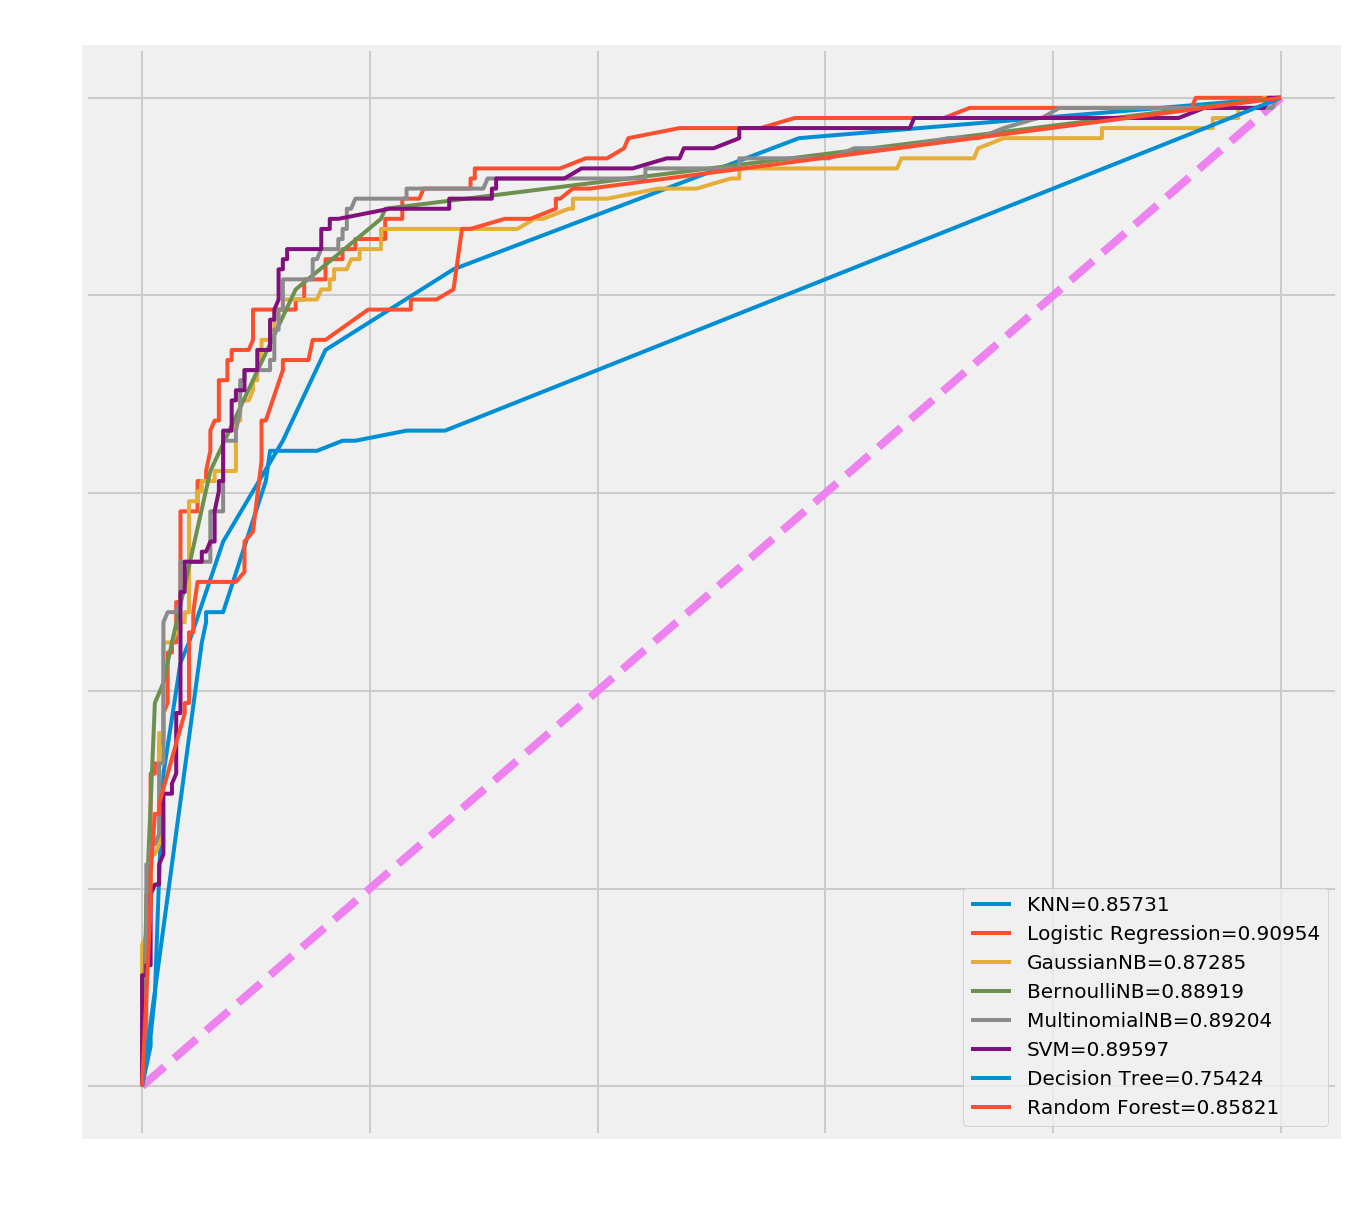

In [44]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')

for name, model in models.items():
    fit = model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, fit.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr,lw=2, 
             label=f'{name}={roc_auc_score(y_test, fit.predict_proba(X_test)[:,1]):.5}')
    leg = plt.legend()
    for text in leg.get_texts():
        plt.setp(text, color = 'k')
plt.show();

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=4444)
metrics = ['accuracy', 'precision', 'recall', 'f1','roc_auc']
modeldict = {}
for name, model in models.items():
    modeldict[name] = []
    for metric in metrics:
        modeldict[name].append(
            np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring=metric)))

In [46]:
pd.DataFrame(modeldict,metrics).transpose()

,accuracy,precision,recall,f1,roc_auc
KNN,0.828400,0.837056,0.359175,0.500785,0.850704
Logistic Regression,0.871889,0.780593,0.635257,0.697903,0.884360
GaussianNB,0.831985,0.618167,0.746173,0.674388,0.881016
BernoulliNB,0.846047,0.735358,0.586328,0.634396,0.865559
MultinomialNB,0.844864,0.760459,0.500473,0.601244,0.871902
SVM,0.865999,0.800559,0.575252,0.668997,0.868820
Decision Tree,0.810781,0.616167,0.552176,0.581677,0.714095
Random Forest,0.830760,0.706443,0.554194,0.623881,0.835143


In [47]:
X2 = aa3.loc[:,cats]
y2 = aa3['oscwin']

In [48]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

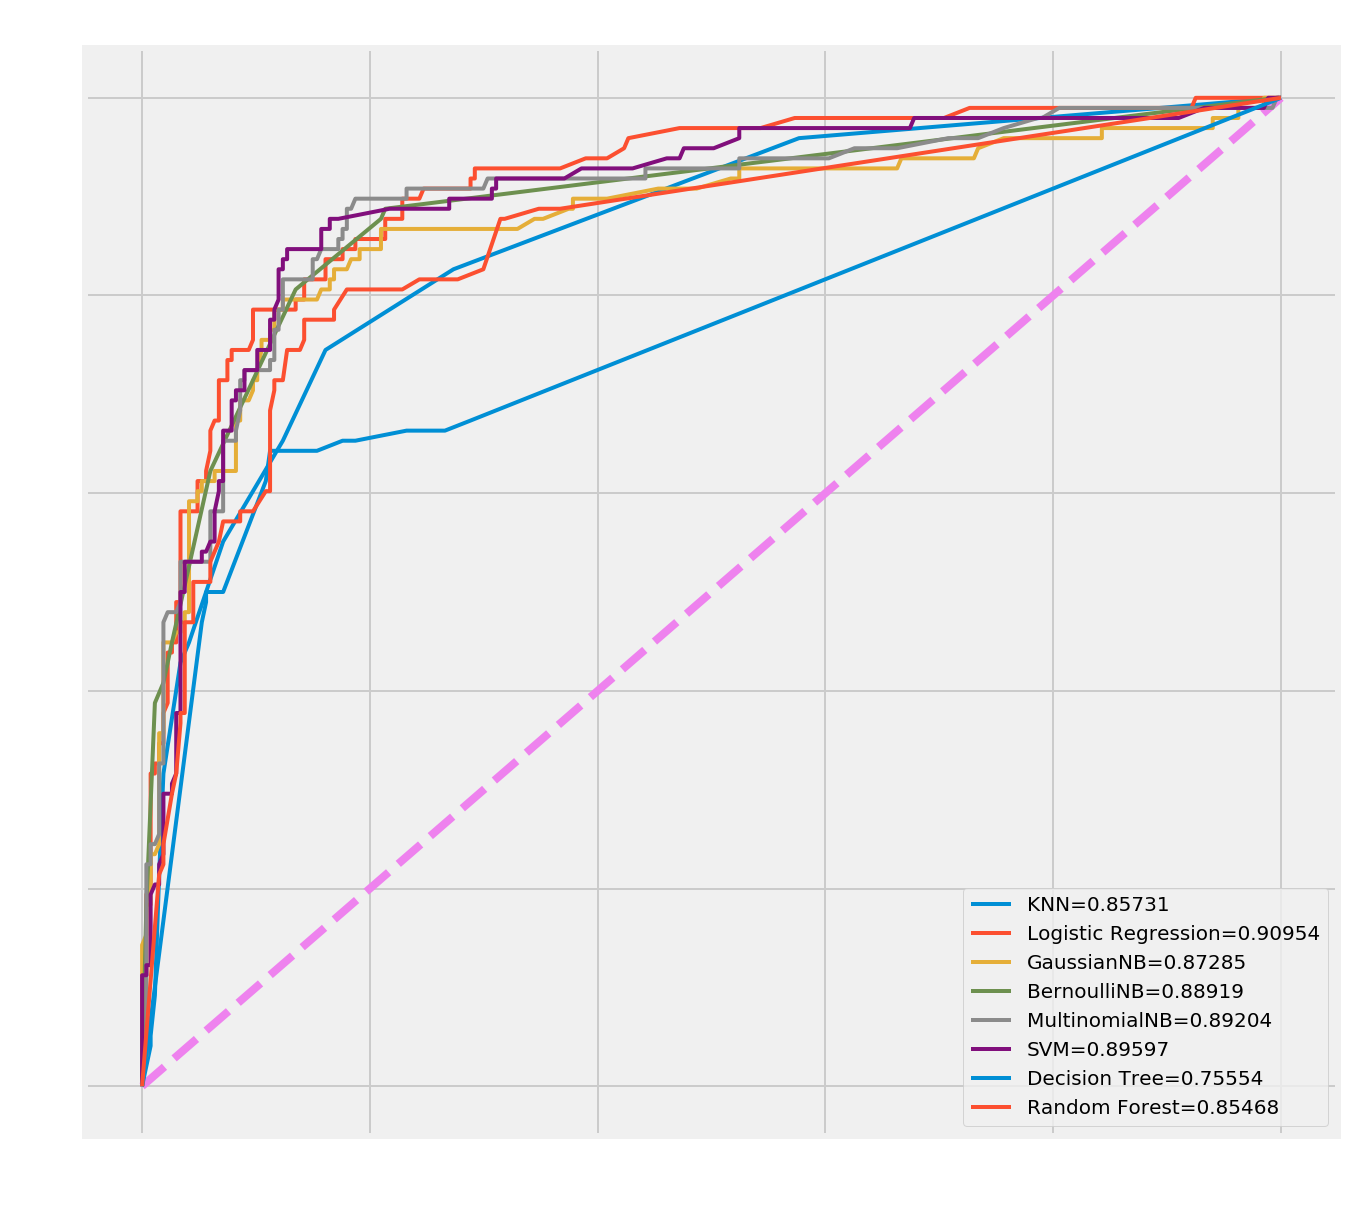

In [49]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')

for name, model in models.items():
    fit = model.fit(X2_train, y2_train)
    fpr, tpr, thresholds = roc_curve(y_test, fit.predict_proba(X2_test)[:,1])
    plt.plot(fpr, tpr,lw=2, 
        label=f'{name}={roc_auc_score(y2_test, fit.predict_proba(X2_test)[:,1]):.5}')
    leg = plt.legend()
    for text in leg.get_texts():
        plt.setp(text, color = 'k')
plt.show();

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=4444)
metrics = ['accuracy', 'precision', 'recall', 'f1','roc_auc']
modeldict2 = {}
for name, model in models.items():
    modeldict2[name] = []
    for metric in metrics:
        modeldict2[name].append(
            np.mean(cross_val_score(model, X2_train, y2_train, cv=kf, scoring=metric)))

In [51]:
pd.DataFrame(modeldict2,metrics).transpose()

,accuracy,precision,recall,f1,roc_auc
KNN,0.828400,0.837056,0.359175,0.500785,0.850704
Logistic Regression,0.871889,0.780593,0.635257,0.697903,0.884360
GaussianNB,0.831985,0.618167,0.746173,0.674388,0.881016
BernoulliNB,0.846047,0.735358,0.586328,0.634396,0.865559
MultinomialNB,0.844864,0.760459,0.500473,0.601244,0.871902
SVM,0.865999,0.800559,0.575252,0.668997,0.868820
Decision Tree,0.810788,0.614539,0.553358,0.587705,0.714378
Random Forest,0.830774,0.665791,0.583346,0.623213,0.804073


In [52]:
pd.DataFrame(modeldict,metrics).transpose()

,accuracy,precision,recall,f1,roc_auc
KNN,0.828400,0.837056,0.359175,0.500785,0.850704
Logistic Regression,0.871889,0.780593,0.635257,0.697903,0.884360
GaussianNB,0.831985,0.618167,0.746173,0.674388,0.881016
BernoulliNB,0.846047,0.735358,0.586328,0.634396,0.865559
MultinomialNB,0.844864,0.760459,0.500473,0.601244,0.871902
SVM,0.865999,0.800559,0.575252,0.668997,0.868820
Decision Tree,0.810781,0.616167,0.552176,0.581677,0.714095
Random Forest,0.830760,0.706443,0.554194,0.623881,0.835143


In [53]:
randomforest = RandomForestClassifier(n_estimators=10)

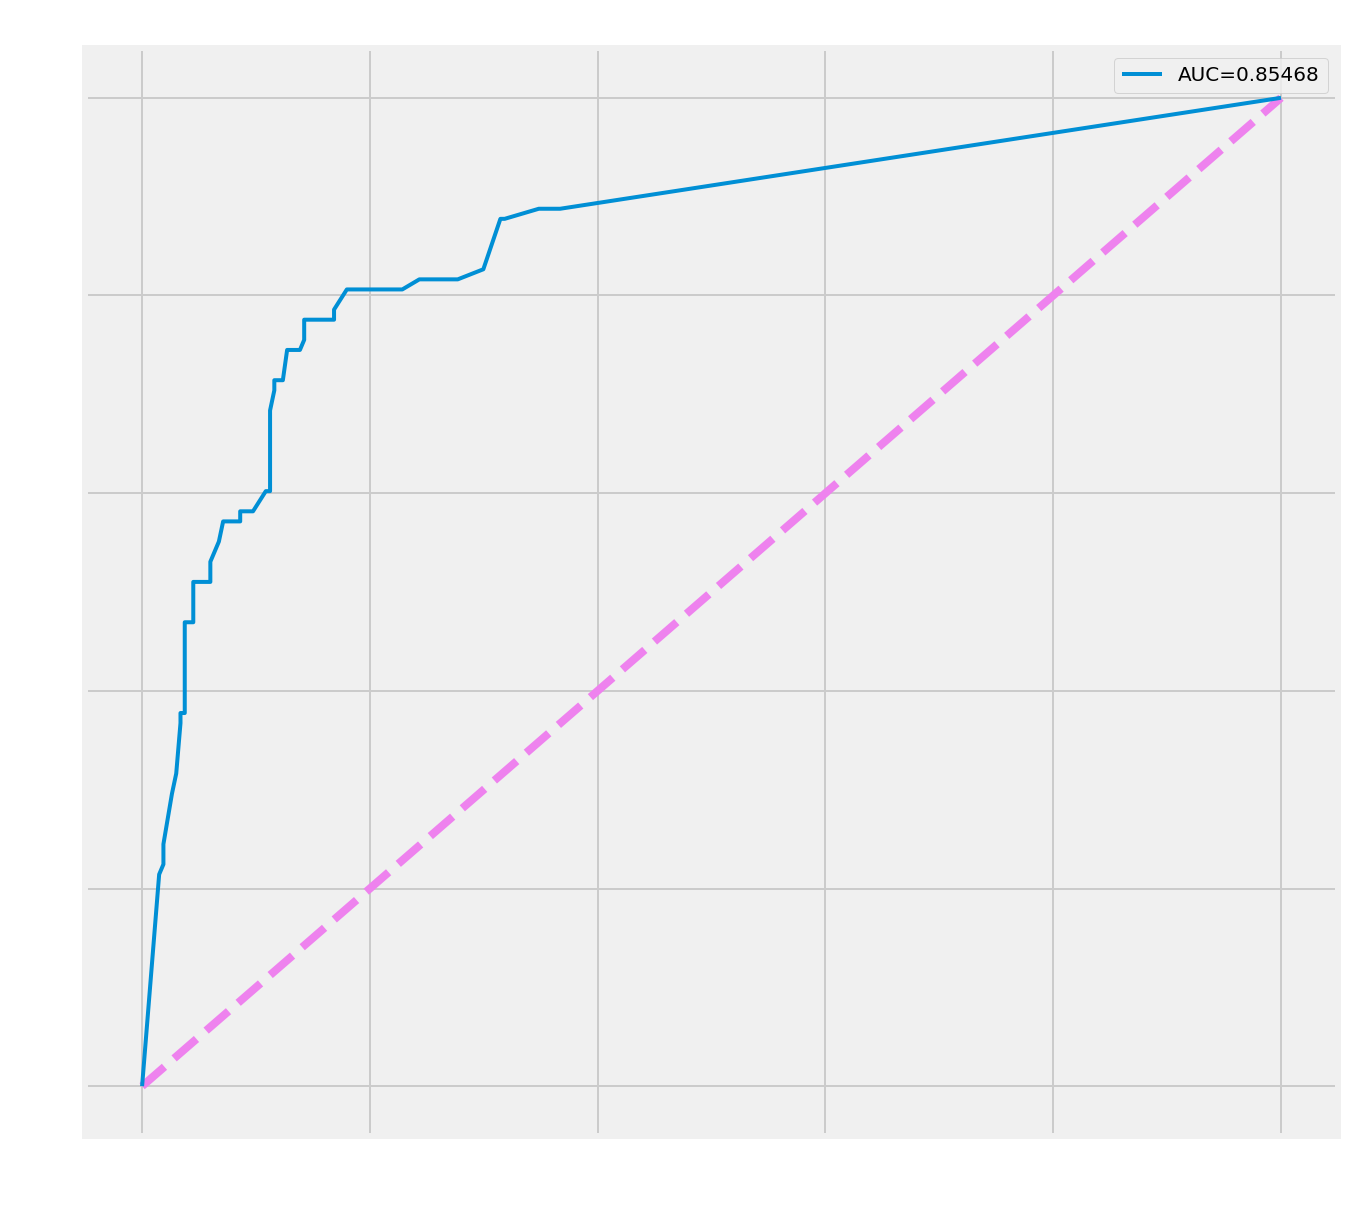

In [54]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')


fit2 = randomforest.fit(X2_train, y2_train)
fpr2, tpr2, thresholds2 = roc_curve(y2_test, fit.predict_proba(X2_test)[:,1])
plt.plot(fpr2, tpr2,lw=2, 
         label=f'AUC={roc_auc_score(y2_test, fit.predict_proba(X2_test)[:,1]):.5}')
leg = plt.legend()
for text in leg.get_texts():
    plt.setp(text, color = 'k')
plt.show();

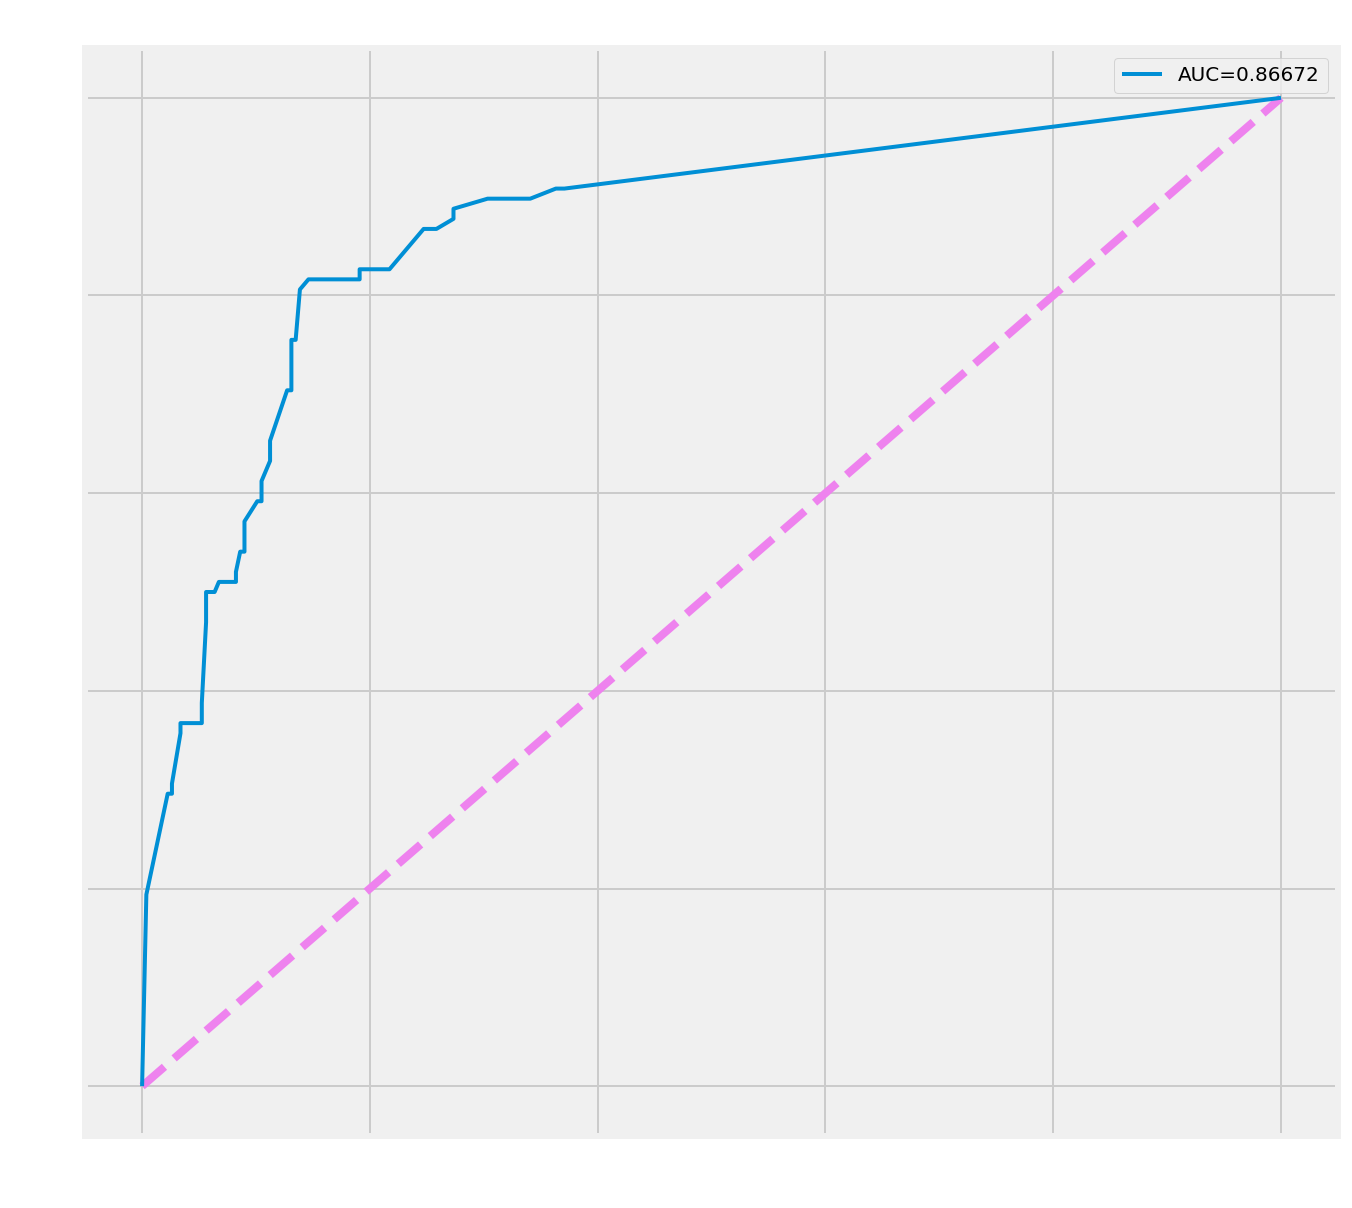

In [55]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')


fit = randomforest.fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, fit.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2, 
         label=f'AUC={roc_auc_score(y_test, fit.predict_proba(X_test)[:,1]):.5}')
leg = plt.legend()
for text in leg.get_texts():
    plt.setp(text, color = 'k')
plt.show();

In [56]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [60]:
randomforest = RandomForestClassifier(n_estimators=10)
rffit = randomforest.fit(X2_train, y2_train)
rfy2_test_pred = rffit.predict(X2_test)
np.sum(abs(y2_test - rfy2_test_pred))

66

In [61]:
logreg = LogisticRegression(solver='lbfgs', C=10,max_iter=1000)
logreg.fit(X2_train, y2_train)
lry2_test_pred = logreg.predict(X2_test)
np.sum(abs(y2_test - lry2_test_pred))

51

In [62]:
bnb = BernoulliNB()
bnbfit = bnb.fit(X2_train, y2_train)
bnby2_test_pred = bnbfit.predict(X2_test)
np.sum(abs(y2_test - bnby2_test_pred))

53

In [63]:
mnb = MultinomialNB()
mnbfit = mnb.fit(X2_train, y2_train)
mnby2_test_pred = mnbfit.predict(X2_test)
np.sum(abs(y2_test - mnby2_test_pred))

59

In [64]:
svm = SVC(gamma='auto',probability=True)
svmfit = svm.fit(X2_train, y2_train)
svmy2_test_pred = svmfit.predict(X2_test)
np.sum(abs(y2_test - svmy2_test_pred))

58

# Modeling each category separately

In [66]:
cats = ['ggwin','guildwin2','bawin','tomato_st','meta_st','numnom']# + dumdums

In [67]:
bestdir = aa2[aa2.category == 'director']
bestpic = aa2[aa2.category == 'picture']
bestscp = aa2[aa2.category == 'screenplay']
bestact = aa2[aa2.category.str.find('act') > -1]

In [68]:
bd_in_bp = []
for row in bestpic.itertuples():
    bd = bestdir[bestdir.movie_title == row.movie_title][bestdir.year_film == row.year_film].movie_title
    if np.array(bd) == [row.movie_title]:
        bd_in_bp.append(1)
    else:
        bd_in_bp.append(0)
bestpic['dirnom'] = bd_in_bp

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
bd_in_bs = []
for row in bestscp.itertuples():
    bd = bestdir[bestdir.movie_title == row.movie_title][bestdir.year_film == row.year_film].movie_title
    if np.array(bd) == [row.movie_title]:
        bd_in_bs.append(1)
    else:
        bd_in_bs.append(0)
bestscp['dirnom'] = bd_in_bs

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
bp_in_ba = []
for row in bestact.itertuples():
    bp = bestpic[bestpic.movie_title == row.movie_title][bestpic.year_film == row.year_film].movie_title
    if np.array(bp) == [row.movie_title]:
        bp_in_ba.append(1)
    else:
        bp_in_ba.append(0)
bestact['picnom'] = bp_in_ba

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
bp_in_bs = []
for row in bestscp.itertuples():
    bp = bestpic[bestpic.movie_title == row.movie_title][bestpic.year_film == row.year_film].movie_title
    if np.array(bp) == [row.movie_title]:
        bp_in_bs.append(1)
    else:
        bp_in_bs.append(0)
bestscp['picnom'] = bp_in_bs

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
diry = bestdir['oscwin']
dirX = bestdir.loc[:,cats]
picy = bestpic['oscwin']
picX = bestpic.loc[:,cats+['dirnom']]
scpy = bestscp['oscwin']
scpX = bestscp.loc[:,cats+['picnom']+['dirnom']]
acty = bestact['oscwin']
actX = bestact.loc[:,cats]

In [73]:
dirX_train, dirX_test, diry_train, diry_test = train_test_split(dirX, diry, test_size=0.3, random_state=42)
picX_train, picX_test, picy_train, picy_test = train_test_split(picX, picy, test_size=0.3, random_state=42)
scpX_train, scpX_test, scpy_train, scpy_test = train_test_split(scpX, scpy, test_size=0.3, random_state=42)
actX_train, actX_test, acty_train, acty_test = train_test_split(actX, acty, test_size=0.3, random_state=42)

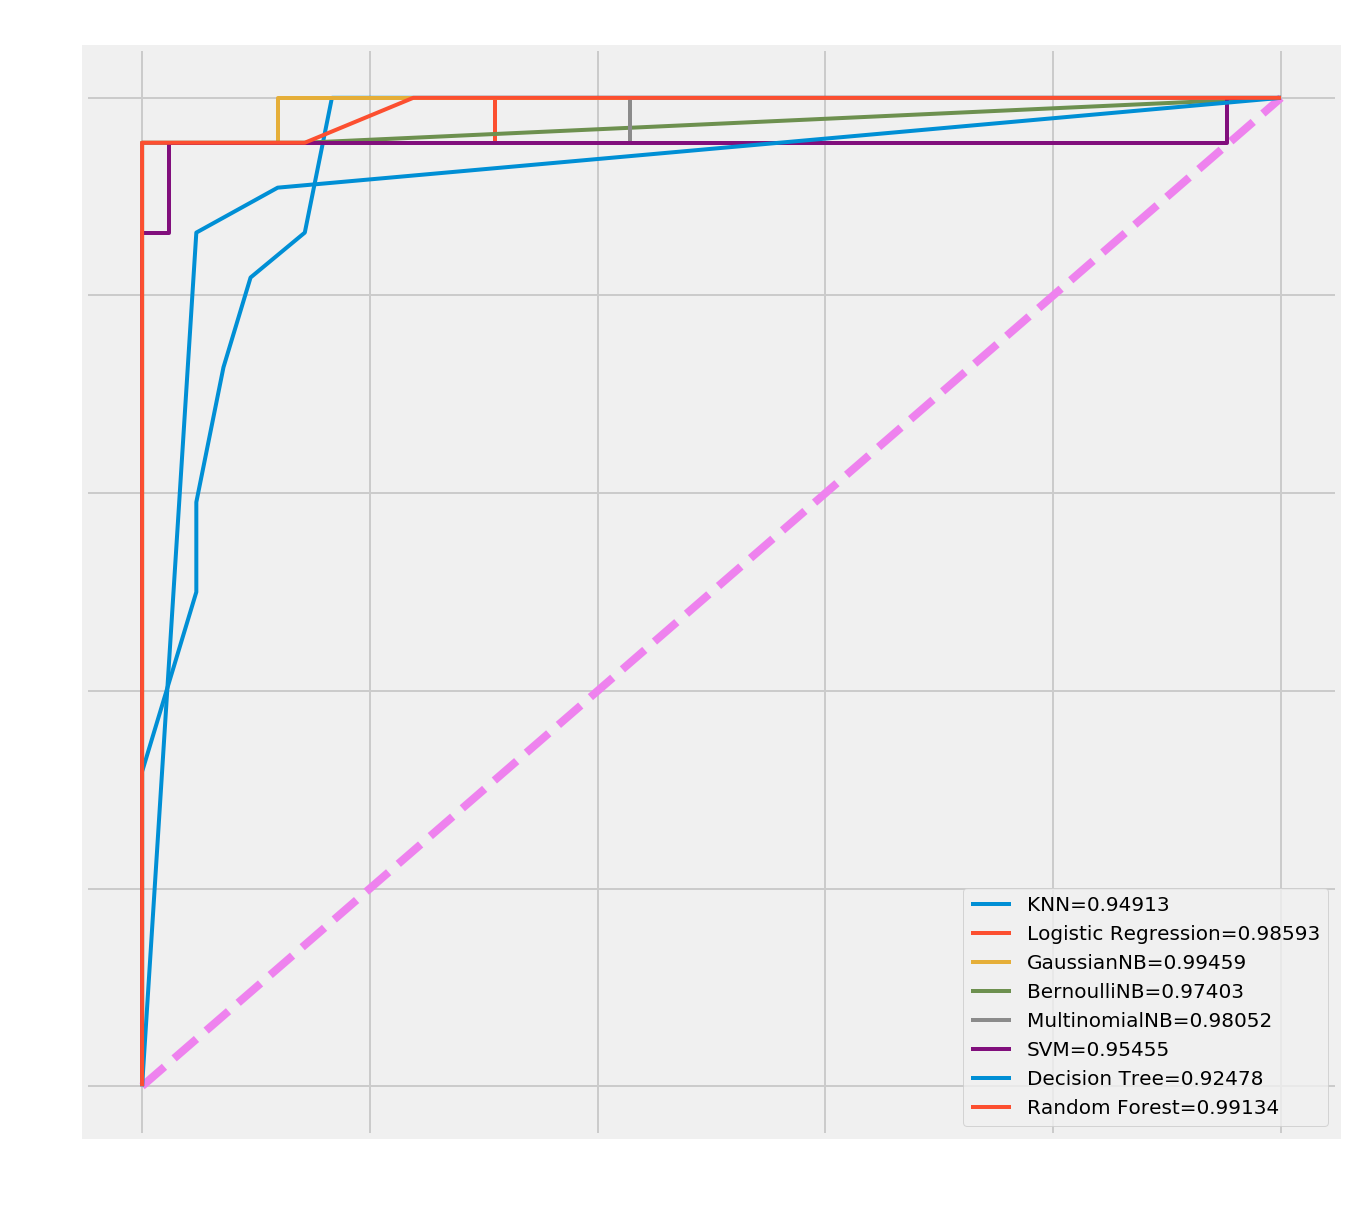

In [74]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Director ROC curve')

for name, model in models.items():
    fit = model.fit(dirX_train, diry_train)
    fpr, tpr, thresholds = roc_curve(diry_test, fit.predict_proba(dirX_test)[:,1])
    plt.plot(fpr, tpr,lw=2, 
             label=f'{name}={roc_auc_score(diry_test, fit.predict_proba(dirX_test)[:,1]):.5}')
    leg = plt.legend()
    for text in leg.get_texts():
        plt.setp(text, color = 'k')
plt.show();

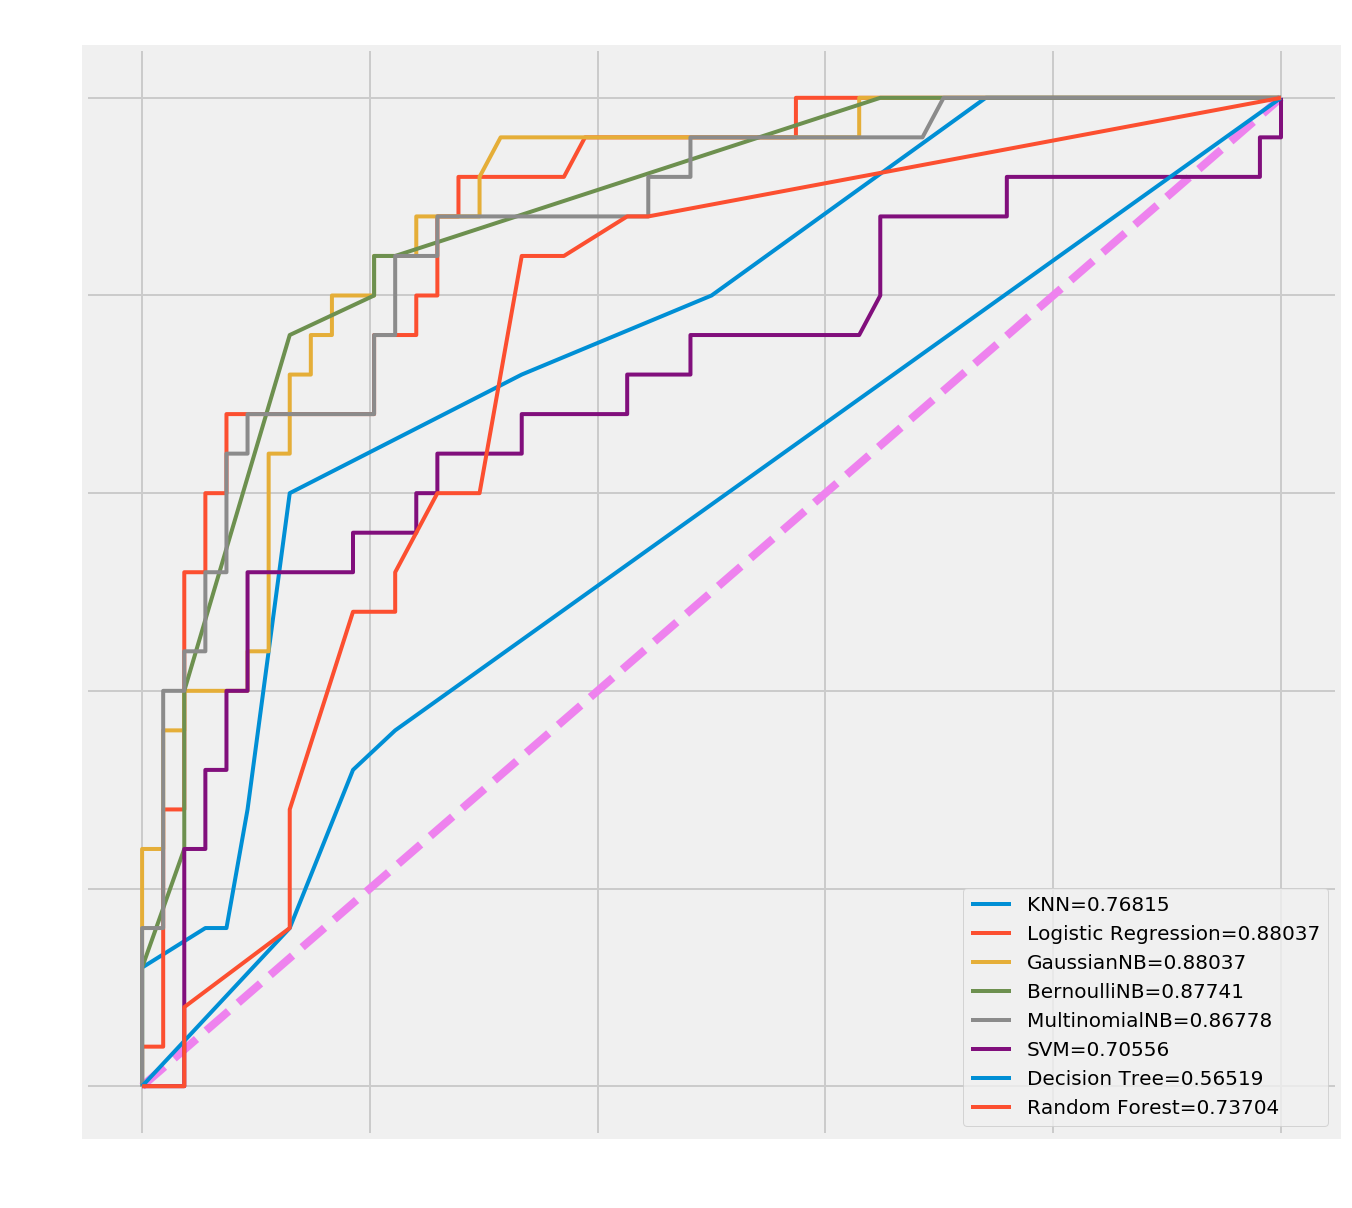

In [75]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Picture ROC curve')

for name, model in models.items():
    fit = model.fit(picX_train, picy_train)
    fpr, tpr, thresholds = roc_curve(picy_test, fit.predict_proba(picX_test)[:,1])
    plt.plot(fpr, tpr,lw=2, 
             label=f'{name}={roc_auc_score(picy_test, fit.predict_proba(picX_test)[:,1]):.5}')
    leg = plt.legend()
    for text in leg.get_texts():
        plt.setp(text, color = 'k')
plt.show();

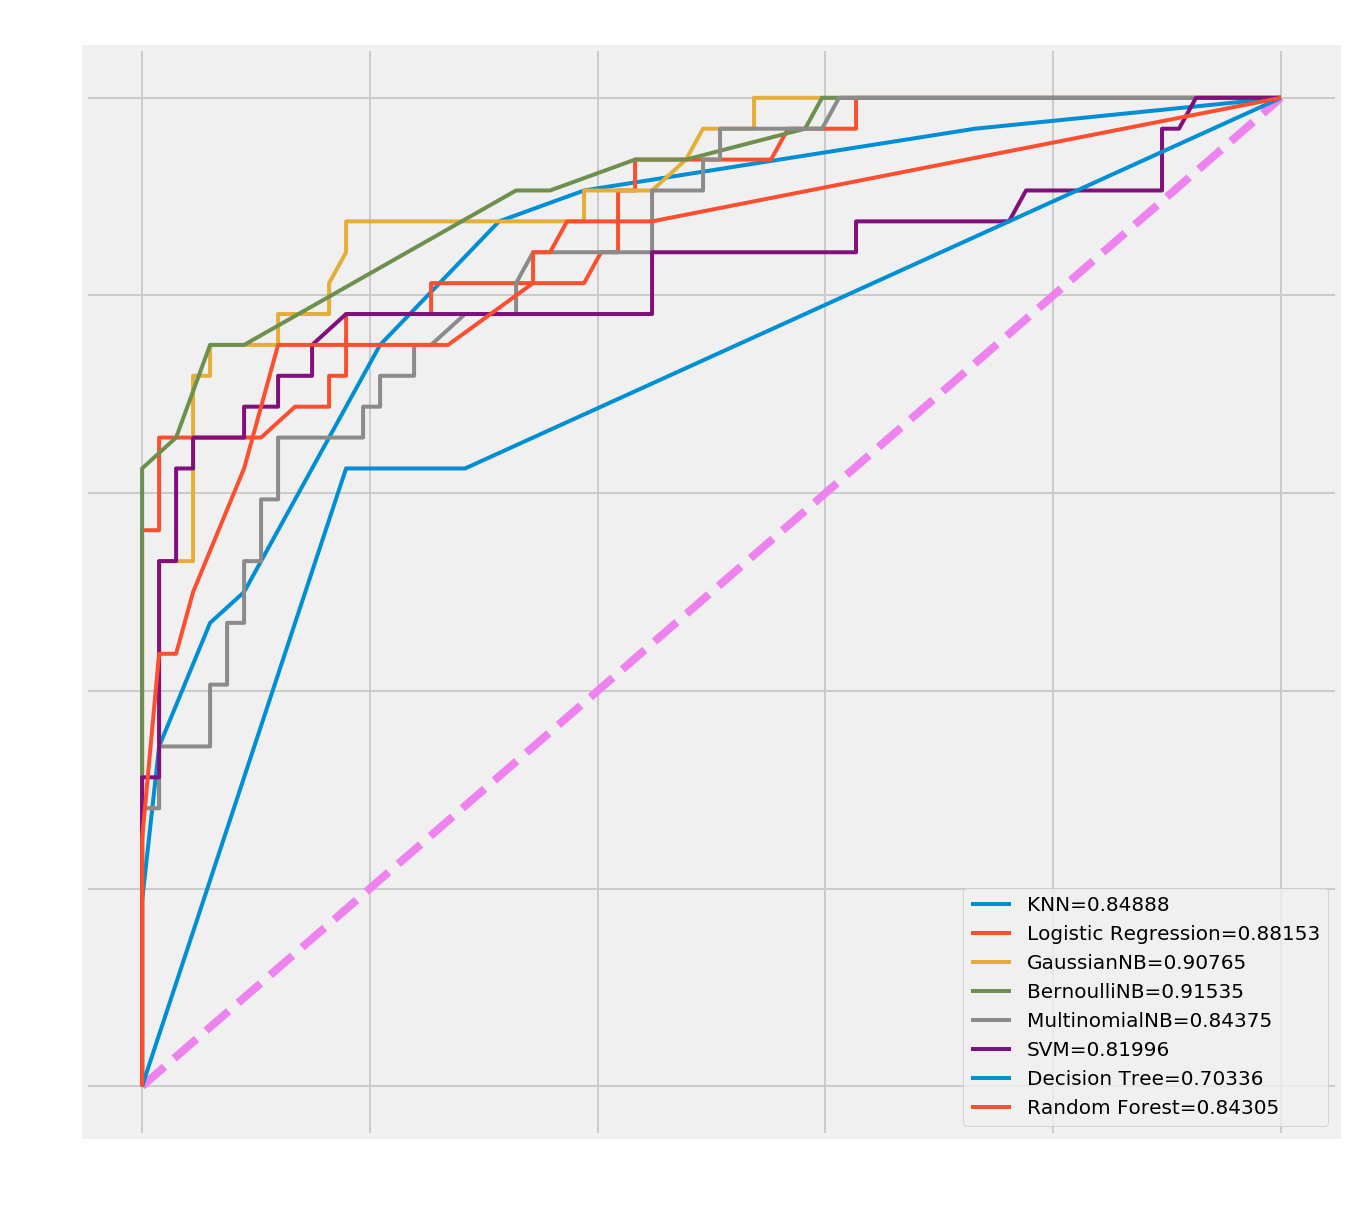

In [76]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Screenplay ROC curve')

for name, model in models.items():
    fit = model.fit(scpX_train, scpy_train)
    fpr, tpr, thresholds = roc_curve(scpy_test, fit.predict_proba(scpX_test)[:,1])
    plt.plot(fpr, tpr,lw=2, 
             label=f'{name}={roc_auc_score(scpy_test, fit.predict_proba(scpX_test)[:,1]):.5}')
    leg = plt.legend()
    for text in leg.get_texts():
        plt.setp(text, color = 'k')
plt.show();

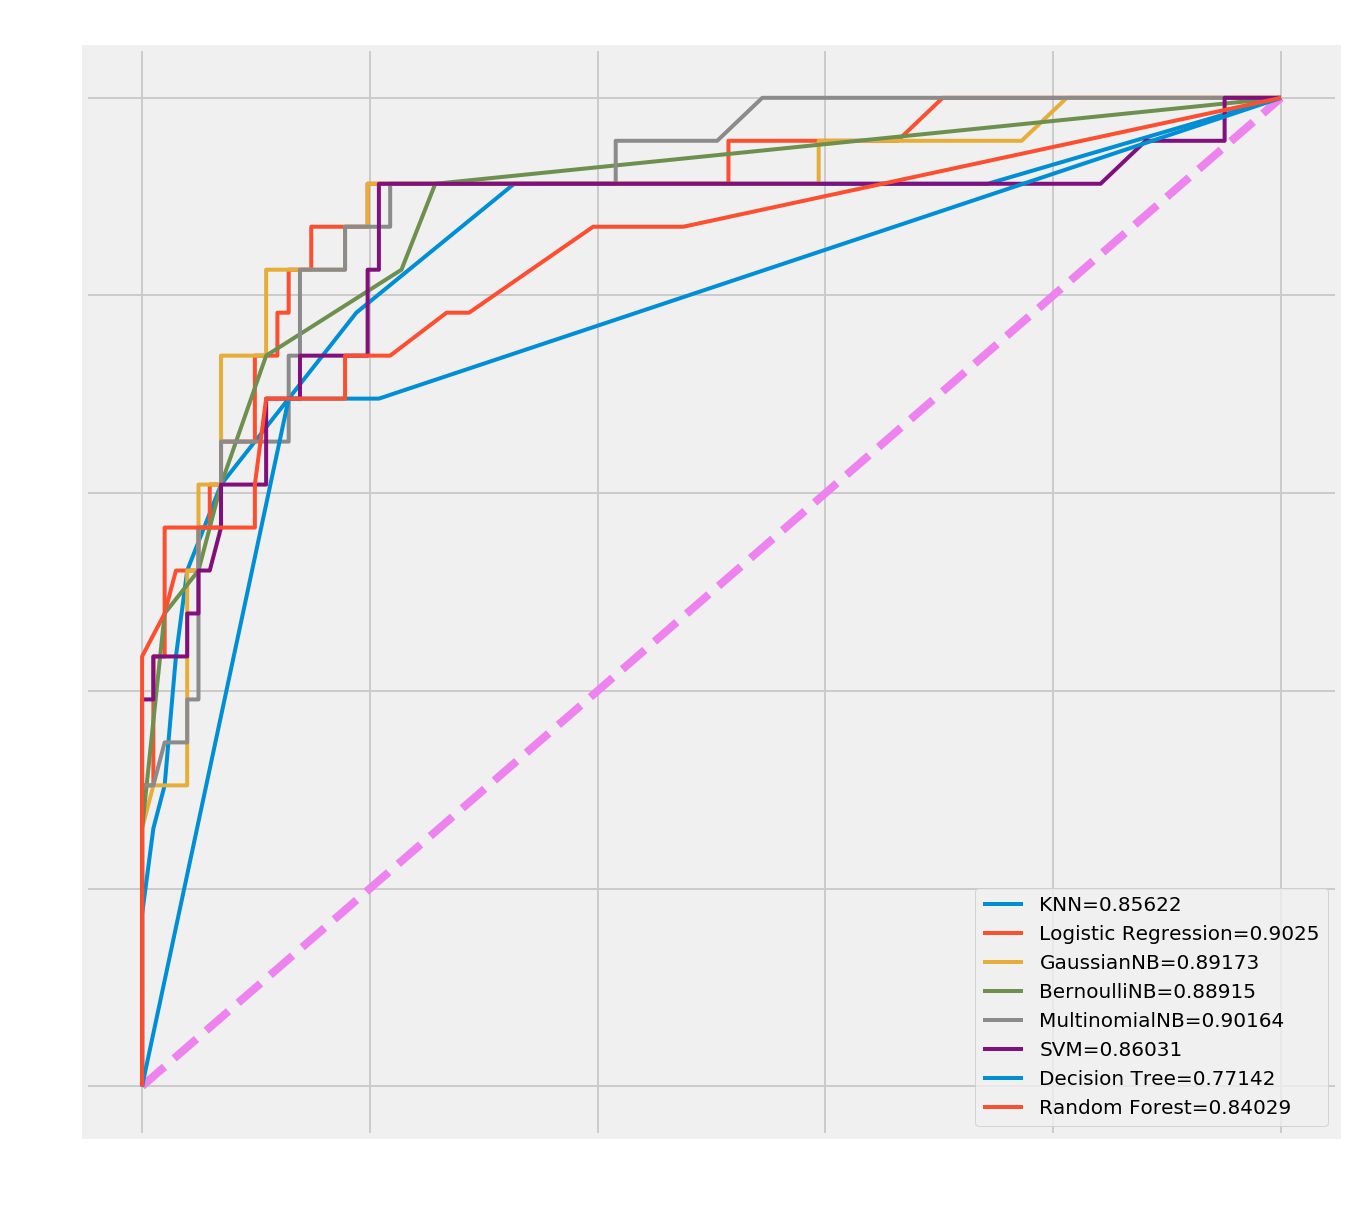

In [77]:
plt.figure(figsize=[10,10])
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Actor ROC curve')

for name, model in models.items():
    fit = model.fit(actX_train, acty_train)
    fpr, tpr, thresholds = roc_curve(acty_test, fit.predict_proba(actX_test)[:,1])
    plt.plot(fpr, tpr,lw=2, 
             label=f'{name}={roc_auc_score(acty_test, fit.predict_proba(actX_test)[:,1]):.5}')
    leg = plt.legend()
    for text in leg.get_texts():
        plt.setp(text, color = 'k')
plt.show();

In [78]:
from sklearn.metrics import confusion_matrix, classification_report

In [79]:
dircats = cats
piccats = cats+['dirnom']
scpcats = cats+['picnom']+['dirnom']
actcats = cats

In [82]:
lrdir = LogisticRegression(solver='lbfgs', C=10,max_iter=1000)
lrdir.fit(dirX_train, diry_train)
lrdiry_test_pred = lrdir.predict(dirX_test)
print(f'{np.sum(abs(diry_test - lrdiry_test_pred))}/{len(diry_test)}')
print(np.sum(abs(diry_test - lrdiry_test_pred))/len(diry_test))

1/64
0.015625


In [83]:
print(dircats)
print(lrdir.coef_)

['ggwin', 'guildwin2', 'bawin', 'tomato_st', 'meta_st', 'numnom']
[[-0.04963552  4.95737608  2.24680542 -0.17538524 -0.60624337  0.28267096]]


In [84]:
print(classification_report(diry_test,lrdiry_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.95      0.98        22

    accuracy                           0.98        64
   macro avg       0.99      0.98      0.98        64
weighted avg       0.98      0.98      0.98        64



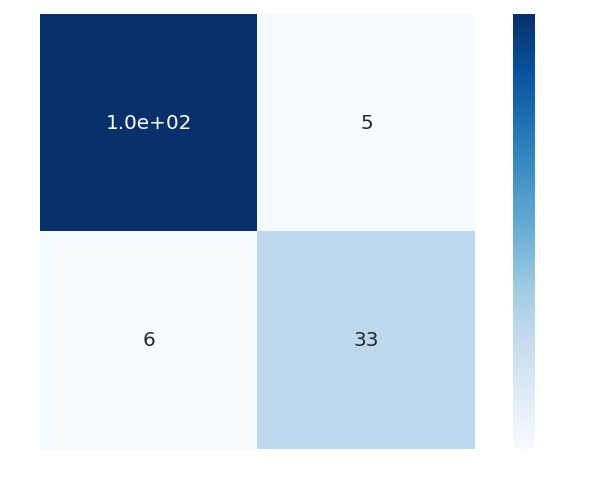

In [85]:
sns.heatmap(confusion_matrix(diry_train, lrdir.predict(dirX_train)), 
            xticklabels=['Predicted Loss', 'Predicted Win'], 
            yticklabels=['Actual Loss', 'Actual Win'], 
            cmap=plt.cm.Blues, annot=True, square=True);

In [86]:
lrpic = LogisticRegression(solver='lbfgs', C=10,max_iter=1000)
lrpic.fit(picX_train, picy_train)
lrpicy_test_pred = lrpic.predict(picX_test)
print(f'{np.sum(abs(picy_test - lrpicy_test_pred))}/{len(picy_test)}')
print(np.sum(abs(picy_test - lrpicy_test_pred))/len(picy_test))

19/79
0.24050632911392406


In [87]:
print(piccats)
print(lrpic.coef_)

['ggwin', 'guildwin2', 'bawin', 'tomato_st', 'meta_st', 'numnom', 'dirnom']
[[ 1.30876487  0.60310603  0.97257059 -0.13711266 -0.04965517  0.12691984
   2.26101557]]


In [88]:
print(classification_report(picy_test,lrpicy_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85        54
           1       0.88      0.28      0.42        25

    accuracy                           0.76        79
   macro avg       0.81      0.63      0.64        79
weighted avg       0.79      0.76      0.71        79



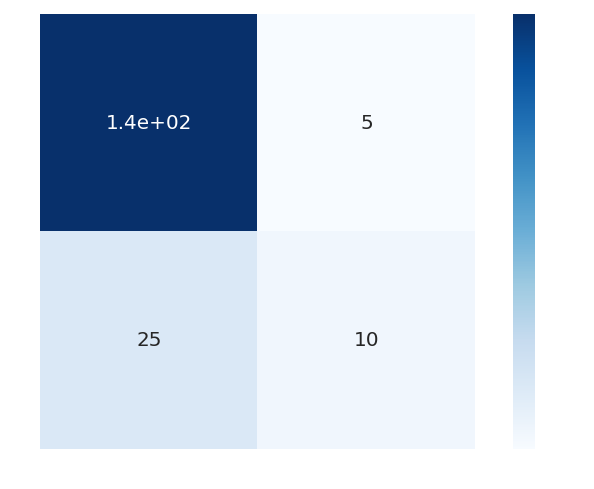

In [89]:
sns.heatmap(confusion_matrix(picy_train, lrpic.predict(picX_train)), 
            xticklabels=['Predicted Loss', 'Predicted Win'], 
            yticklabels=['Actual Loss', 'Actual Win'], 
            cmap=plt.cm.Blues, annot=True, square=True);

In [91]:
lrscp = LogisticRegression(solver='lbfgs', C=10,max_iter=1000)
lrscp.fit(scpX_train, scpy_train)
lrscpy_test_pred = lrscp.predict(scpX_test)
print(f'{np.sum(abs(scpy_test - lrscpy_test_pred))}/{len(scpy_test)}')
print(np.sum(abs(scpy_test - lrscpy_test_pred))/len(scpy_test))

13/99
0.13131313131313133


In [92]:
print(scpcats)
print(lrscp.coef_)

['ggwin', 'guildwin2', 'bawin', 'tomato_st', 'meta_st', 'numnom', 'picnom', 'dirnom']
[[ 2.12861332e+00  2.47039544e+00  7.56165346e-01 -8.65950784e-02
  -5.73467292e-02 -1.61907686e-03  9.34564683e-01  4.77707843e-01]]


In [93]:
print(classification_report(scpy_test,lrscpy_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91        67
           1       0.95      0.62      0.75        32

    accuracy                           0.87        99
   macro avg       0.90      0.81      0.83        99
weighted avg       0.88      0.87      0.86        99



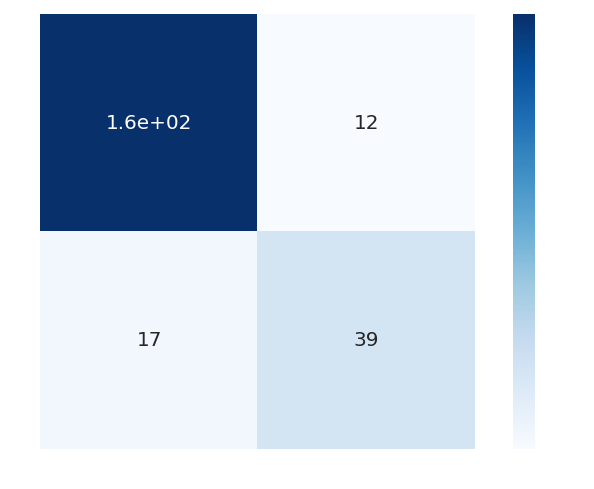

In [94]:
sns.heatmap(confusion_matrix(scpy_train, lrscp.predict(scpX_train)), 
            xticklabels=['Predicted Loss', 'Predicted Win'], 
            yticklabels=['Actual Loss', 'Actual Win'], 
            cmap=plt.cm.Blues, annot=True, square=True);

In [96]:
lract = LogisticRegression(solver='lbfgs', C=10,max_iter=1000)
lract.fit(actX_train, acty_train)
lracty_test_pred = lract.predict(actX_test)
print(f'{np.sum(abs(acty_test - lracty_test_pred))}/{len(acty_test)}')
print(np.sum(abs(acty_test - lracty_test_pred))/len(acty_test))

16/124
0.12903225806451613


In [97]:
print(actcats)
print(lract.coef_)

['ggwin', 'guildwin2', 'bawin', 'tomato_st', 'meta_st', 'numnom']
[[ 2.08498724  2.77123537  2.01115861  0.02404277 -0.12933689  0.02623943]]


In [98]:
print(classification_report(acty_test,lracty_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       101
           1       0.67      0.61      0.64        23

    accuracy                           0.87       124
   macro avg       0.79      0.77      0.78       124
weighted avg       0.87      0.87      0.87       124



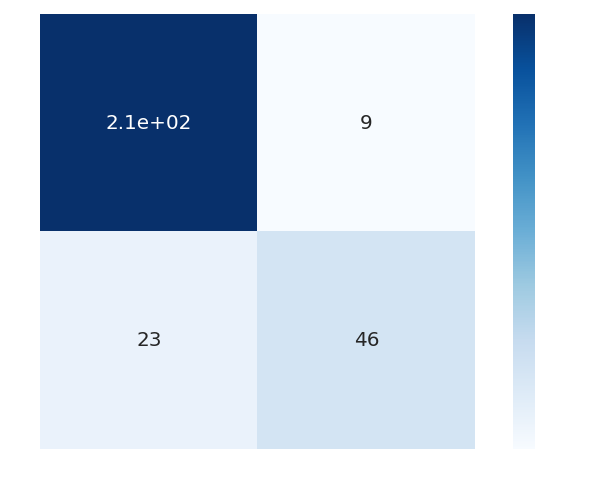

In [99]:
sns.heatmap(confusion_matrix(acty_train, lract.predict(actX_train)), 
            xticklabels=['Predicted Loss', 'Predicted Win'], 
            yticklabels=['Actual Loss', 'Actual Win'], 
            cmap=plt.cm.Blues, annot=True, square=True);

In [100]:
#Best Director
p = [0,1,0,5,5,6]
n = [1,1,1,4,3,10]
j = [0,0,0,2,1,11]
i = [0,0,0,5,5,10]
o = [0,0,0,4,4,10]

In [103]:
print(lrdir.predict_proba([p,n,j,i,o]))
print(logreg.predict_proba([p,n,j,i,o]))

[[0.41502186 0.58497814]
 [0.00631201 0.99368799]
 [0.56209005 0.43790995]
 [0.97021315 0.02978685]
 [0.93713397 0.06286603]]
[[0.51662566 0.48337434]
 [0.03096172 0.96903828]
 [0.87949823 0.12050177]
 [0.90202818 0.09797182]
 [0.90366246 0.09633754]]


In [109]:
#Best Picture
ff = [0,0,0,5,4,4,0]
ir = [0,0,0,5,5,10,1]
jj = [0,0,0,4,1,6,1]
jo = [0,0,0,2,1,11,0]
lw = [0,0,0,5,5,6,0]
ms = [0,0,0,5,5,6,0]
ns = [1,1,1,4,3,10,1]
ou = [1,0,0,4,4,10,1]
pa = [0,1,0,5,5,6,1]

In [114]:
print(lrpic.predict_proba([ff,ir,jj,jo,lw,ms,ns,ou,pa]))
print(logreg.predict_proba([ff[:6],ir[:6],jj[:6],jo[:6],lw[:6],ms[:6],ns[:6],ou[:6],pa[:6]]))

[[0.99152659 0.00847341]
 [0.85685782 0.14314218]
 [0.87668218 0.12331782]
 [0.96489144 0.03510856]
 [0.98962707 0.01037293]
 [0.98962707 0.01037293]
 [0.20892278 0.79107722]
 [0.57295087 0.42704913]
 [0.84475039 0.15524961]]
[[0.95660094 0.04339906]
 [0.90202818 0.09797182]
 [0.92657507 0.07342493]
 [0.87949823 0.12050177]
 [0.94702394 0.05297606]
 [0.94702394 0.05297606]
 [0.03096172 0.96903828]
 [0.67469105 0.32530895]
 [0.51662566 0.48337434]]


In [115]:
#Best Adapted Screenplay
irw = [0,0,0,96,94,10,1,1]
jjw = [0,1,1,80,58,6,1,0]
jow = [0,0,0,68,59,11,1,1]
lww = [0,0,0,95,91,6,1,0]
tpw = [0,0,0,89,75,3,0,0]

In [116]:
print(lrscp.predict_proba([irw,jjw,jow,lww,tpw]))
print(logreg.predict_proba([irw[:6],jjw[:6],jow[:6],lww[:6],tpw[:6]]))

[[9.99999732e-01 2.68338616e-07]
 [9.99867087e-01 1.32912963e-04]
 [9.99977474e-01 2.25255625e-05]
 [9.99999783e-01 2.16947081e-07]
 [9.99999640e-01 3.60345754e-07]]
[[0.56951542 0.43048458]
 [0.00519354 0.99480646]
 [0.44512777 0.55487223]
 [0.67204189 0.32795811]
 [0.52595567 0.47404433]]


In [117]:
#Best Original Screenplay
kow = [0,0,0,5,4,1,0,0]
msw = [0,0,0,5,5,6,1,0]
nsw = [0,0,0,4,3,10,1,1]
ouw = [1,0,0,4,4,10,1,1]
paw = [0,1,1,5,5,6,1,1]

In [119]:
print(lrscp.predict_proba([kow,msw,nsw,ouw,paw]))
print(logreg.predict_proba([kow[:6],msw[:6],nsw[:6],ouw[:6],paw[:6]]))

[[0.97032595 0.02967405]
 [0.93202606 0.06797394]
 [0.8749788  0.1250212 ]
 [0.4686536  0.5313464 ]
 [0.25236617 0.74763383]]
[[0.97315823 0.02684177]
 [0.94702394 0.05297606]
 [0.89247767 0.10752233]
 [0.67469105 0.32530895]
 [0.23735187 0.76264813]]


In [120]:
#Best Actor
abma = [0,0,0,5,5,2]
ldma = [0,0,0,5,5,10]
adma = [0,0,0,5,5,6]
jqma = [1,1,1,4,3,11]
jpma = [0,0,0,5,4,3]

#Best Supporting Actor
thsa = [0,0,0,5,4,1]
ahsa = [0,0,0,5,4,3]
apsa = [0,0,0,5,5,10]
jpsa = [0,0,0,5,5,10]
bpsa = [1,1,1,5,5,10]

#Best Actress
cefa = [0,0,0,4,4,2]
sjfa = [0,0,0,5,5,6]
srfa = [0,0,0,5,5,6]
ctfa = [0,0,0,4,4,3]
rzfa = [1,1,1,5,4,2]

#Best Supporting Actress
kbsa = [0,0,0,4,4,1]
ldsa = [1,1,1,5,5,6]
sjsa = [0,0,0,4,3,6]
fpsa = [0,0,0,5,5,6]
mrsa = [0,0,0,3,3,3]

In [121]:
print(lract.predict_proba([abma,ldma,adma,jqma,jpma]))
print(logreg.predict_proba([abma,ldma,adma,jqma,jpma]))

[[0.97296225 0.02703775]
 [0.96685625 0.03314375]
 [0.97005974 0.02994026]
 [0.02286414 0.97713586]
 [0.96855408 0.03144592]]
[[0.97199595 0.02800405]
 [0.90202818 0.09797182]
 [0.94702394 0.05297606]
 [0.02635389 0.97364611]
 [0.96298905 0.03701095]]


In [122]:
print(lract.predict_proba([thsa,ahsa,apsa,jpsa,bpsa]))
print(logreg.predict_proba([thsa,ahsa,apsa,jpsa,bpsa]))

[[0.97011372 0.02988628]
 [0.96855408 0.03144592]
 [0.96685625 0.03314375]
 [0.96685625 0.03314375]
 [0.02947813 0.97052187]]
[[0.97315823 0.02684177]
 [0.96298905 0.03701095]
 [0.90202818 0.09797182]
 [0.90202818 0.09797182]
 [0.03422781 0.96577219]]


In [126]:
print(lract.predict_proba([cefa,sjfa,srfa,ctfa,rzfa]))
print(logreg.predict_proba([cefa,sjfa,srfa,ctfa,rzfa]))

[[0.97004997 0.02995003]
 [0.97005974 0.02994026]
 [0.97005974 0.02994026]
 [0.96927816 0.03072184]
 [0.03187291 0.96812709]]
[[0.97249867 0.02750133]
 [0.94702394 0.05297606]
 [0.94702394 0.05297606]
 [0.96769687 0.03230313]
 [0.10572728 0.89427272]]


In [127]:
print(lract.predict_proba([kbsa,ldsa,sjsa,fpsa,mrsa]))
print(logreg.predict_proba([kbsa,ldsa,sjsa,fpsa,mrsa]))

[[0.97080297 0.02919703]
 [0.03263383 0.96736617]
 [0.96243965 0.03756035]
 [0.97005974 0.02994026]
 [0.96598293 0.03401707]]
[[0.97660395 0.02339605]
 [0.06438212 0.93561788]
 [0.94157561 0.05842439]
 [0.94702394 0.05297606]
 [0.96827425 0.03172575]]
